# **Fraudulent Card Transaction**

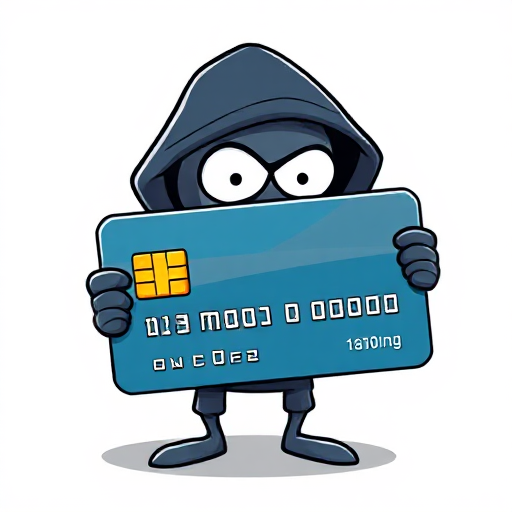

In this project, I built classification models to categorize customers as defaulters or non-defaulters based on information about their accounts and transactions. The dataset was provided by Capital One and is available on their GitHub page: Capital One Data Science Challenge.

The analysis includes data manipulation, data analysis, data modeling, and visualization, along with answering key business questions. The project is primarily implemented in Python, leveraging libraries such as NumPy, pandas, matplotlib, seaborn, and scikit-learn.

In [3]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [5]:
# read  and clean the data
data = pd.read_pickle("transactions.pkl", compression="infer")

# Change type of data in time columns to date time data
for i in ['accountOpenDate', 'transactionDateTime', 'currentExpDate', 'dateOfLastAddressChange'] :
    data[i] = pd.to_datetime(data[i])

# change the type of values from boolean to integers
for i in ["cardPresent", "expirationDateKeyInMatch", "isFraud"]: 
    data[i] = data[i].astype('int64') 
    
#  drop columns that do not have any values
data.drop(['echoBuffer', 'merchantCity','merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd' ], axis=1, inplace=True)    

# create a new column the check the difference between cardCVV and enteredCVV
data["cvvMatch"] = (data.cardCVV == data.enteredCVV).astype('int64')

# drop columns 'cardCVV', 'enteredCVV','accountNumber'
data.drop(['cardCVV', 'enteredCVV','accountNumber'], axis=1, inplace=True)

# fill in missing values with other in ['transactionType','merchantCountryCode'] with other 
data[['transactionType', 'merchantCountryCode','acqCountry','posEntryMode','posConditionCode']] = data[['transactionType', 
                                                                      'merchantCountryCode',
                                                                      'acqCountry',
                                                                      'posEntryMode',
                                                                      'posConditionCode'       
                                                                                    ]].replace("", "Other")

# clean merchant Name 
data['merchantName'] = data['merchantName'].str.replace(r'#\d+', '', regex=True).str.strip()
data['merchantName'] = data['merchantName'].str.lower()

data.head()

customerId  creditLimit  availableMoney transactionDateTime  \
0  737265056       5000.0          5000.0 2016-08-13 14:27:32   
1  737265056       5000.0          5000.0 2016-10-11 05:05:54   
2  737265056       5000.0          5000.0 2016-11-08 09:18:39   
3  737265056       5000.0          5000.0 2016-12-10 02:14:50   
4  830329091       5000.0          5000.0 2016-03-24 21:04:46   

   transactionAmount merchantName acqCountry merchantCountryCode posEntryMode  \
0              98.55         uber         US                  US           02   
1              74.51          amc         US                  US           09   
2               7.47   play store         US                  US           09   
3               7.47   play store         US                  US           09   
4              71.18  tim hortons         US                  US           02   

  posConditionCode  ... currentExpDate accountOpenDate  \
0               01  ...     2023-06-01      2015-03-14   
1               01  ...     2024-02-01      2015-03-14   
2               01  ...     2025-08-01      2015-03-14   
3               01  ...     2025-08-01      2015-03-14   
4               01  ...     2029-10-01      2015-08-06   

  dateOfLastAddressChange cardLast4Digits transactionType currentBalance  \
0              2015-03-14            1803        PURCHASE            0.0   
1              2015-03-14             767        PURCHASE            0.0   
2              2015-03-14             767        PURCHASE            0.0   
3              2015-03-14             767        PURCHASE            0.0   
4              2015-08-06            3143        PURCHASE            0.0   

   cardPresent  expirationDateKeyInMatch  isFraud  cvvMatch  
0            0                         0        0         1  
1            1                         0        0         1  
2            0                         0        0         1  
3            0                         0        0         1  
4            1                         0        0         1  

[5 rows x 21 columns]

In [6]:
data.columns

Index(['customerId', 'creditLimit', 'availableMoney', 'transactionDateTime',
       'transactionAmount', 'merchantName', 'acqCountry',
       'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardLast4Digits', 'transactionType',
       'currentBalance', 'cardPresent', 'expirationDateKeyInMatch', 'isFraud',
       'cvvMatch'],
      dtype='object')

## EXPLORATORY DATA ANALYSIS 

### TARGET
**Is data balanced?**

isFraud
0    98.420958
1     1.579042
Name: proportion, dtype: float64


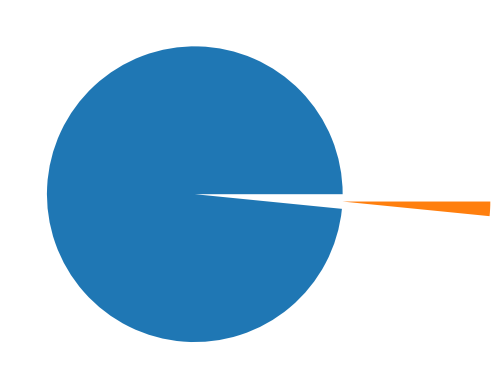

In [9]:
print(data["isFraud"].value_counts(normalize = True) * 100 )
# plot the classes of the target 
target  = data["isFraud"].value_counts(normalize = True) * 100
plt.pie(target.values, target.index);

The dataset is highly unbalanced with 98.42% nonfraud and 1.58% fraud. 

In [13]:
non_fraud = data["isFraud"].value_counts(normalize = True)[0]
fraud = data["isFraud"].value_counts(normalize = True)[1]
print(f'The imbalance ration is almost 1: {int(non_fraud/fraud)} which shows a severe imbalance in our data')

The imbalance ration is almost 1: 62 which shows a severe imbalance in our data


<Axes: xlabel='availableMoney', ylabel='transactionAmount'>

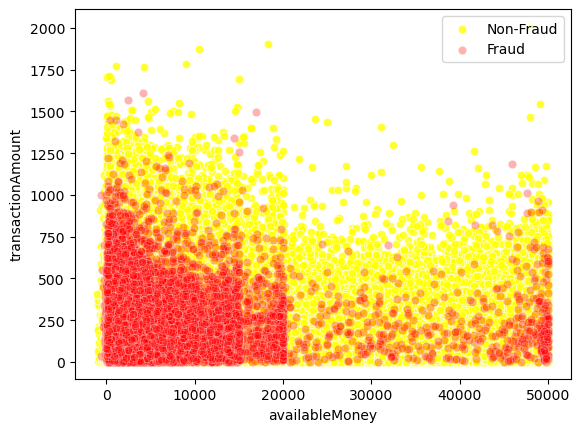

In [16]:
# Filter data by fraud status
fraud = data[data['isFraud'] == 1]
non_fraud = data[data['isFraud'] == 0]

# Plot non-fraud transactions (less transparent)
sns.scatterplot(data=non_fraud, x='availableMoney', y='transactionAmount', 
                color='yellow', alpha=0.8, label='Non-Fraud')

# Plot fraud transactions (more transparent)
sns.scatterplot(data=fraud, x='availableMoney', y='transactionAmount', 
                color='red', alpha=0.3, label='Fraud')

### Cusromer Id Column Analysis

**Question 2: Does fraud occur only among customers with a high number of transactions?**

In [18]:
# customers with the highest number of transaction
data.customerId.value_counts().head(10)

customerId
380680241    32850
882815134    13189
570884863    10867
246251253    10172
369308035     7229
724518977     6283
894938833     6101
419709514     5930
832842201     5850
208319653     5235
Name: count, dtype: int64

In [19]:
pd.crosstab(data.customerId, data.isFraud,  normalize='index').sort_values(by = 1, ascending = False).head(10)

isFraud            0         1
customerId                    
749645399   0.000000  1.000000
356886744   0.000000  1.000000
494400203   0.500000  0.500000
666461201   0.500000  0.500000
275266909   0.666667  0.333333
938195288   0.692982  0.307018
319012201   0.714286  0.285714
336236533   0.722222  0.277778
838703913   0.726415  0.273585
672316951   0.751724  0.248276

In [20]:
data_id = data.copy()
customer_transaction_count = data_id.groupby('customerId').size()
data_id['total_trans_perCost'] = data_id['customerId'].map(customer_transaction_count)
data_id[['total_trans_perCost', 'isFraud']].corr(method='spearman')

total_trans_perCost  isFraud
total_trans_perCost               1.0000   0.0183
isFraud                           0.0183   1.0000

### Metchant Related Columns

In [22]:
merchant_data = data[['merchantName', 'merchantCountryCode', 'merchantCategoryCode','transactionAmount', 'isFraud']]
merchant_data.groupby('isFraud').agg(merchantName = ('merchantName', 'nunique'),
                                   merchantCountryCode = ('merchantCountryCode', 'nunique'),
                                   merchantCategoryCode = ('merchantCategoryCode', 'nunique'))

merchantName  merchantCountryCode  merchantCategoryCode
isFraud                                                         
0                 205                    5                    19
1                 173                    5                    13

in 13 out of 19 merchantCategoryCode fraud happen and in 173 out of 205 merchantName

**Question 3: country with the highest rate of fraud**

In [25]:
# Create a pivot table that aggregates by count and sum
country = merchant_data.pivot_table(
    index='merchantCountryCode', 
    columns='isFraud', 
    values='transactionAmount', 
    aggfunc={'transactionAmount': ['count', 'sum']}, 
    fill_value=0
)
country['rate of fraud'] = round((country['count'][1]/country['count'][0])*100, 2)
country['% Fraud Amount'] = round((country['sum'][1]/country['sum'][0]) * 100, 2)
country[['rate of fraud', '% Fraud Amount']]

rate of fraud % Fraud Amount
isFraud                                         
merchantCountryCode                             
CAN                          2.36           4.26
MEX                          2.08           3.17
Other                       12.77          25.78
PR                           1.76           3.17
US                           1.59           2.64

#### Merhcant Category Code

**Question 4 : Safest and riskier merchant category**

In [28]:
category = merchant_data.pivot_table(
    index='merchantCategoryCode', 
    columns='isFraud', 
    values='transactionAmount', 
    aggfunc={'transactionAmount': ['count', 'sum']}, 
    fill_value=0
)
category['rate of fraud'] = round((category['count'][1]/category['count'][0])*100, 2)
category['% Fraud Amount'] = round((category['sum'][1]/category['sum'][0]) * 100, 2)
category[['rate of fraud', '% Fraud Amount']].sort_values(by = 'rate of fraud',ascending = False)


rate of fraud % Fraud Amount
isFraud                                          
merchantCategoryCode                             
airline                       3.59           5.25
rideshare                     2.55           4.19
online_retail                 2.50           4.22
online_gifts                  2.48           4.25
furniture                     1.41           1.79
food                          1.36           1.98
auto                          1.28           1.93
entertainment                 1.21           1.52
fastfood                      0.97           1.21
subscriptions                 0.95           1.49
hotels                        0.74           1.10
health                        0.47           0.84
personal care                 0.46           0.50
mobileapps                    0.00           0.00
fuel                          0.00           0.00
food_delivery                 0.00           0.00
online_subscriptions          0.00           0.00
cable/phone                   0.00           0.00
gym                           0.00           0.00

In [29]:
for i in ['personal care','mobileapps','fuel','food_delivery', 'online_subscriptions','cable/phone','gym']:
    data["merchantCategoryCode"] = data["merchantCategoryCode"].replace(i, "Other")

#### Merchant Name

In [31]:
name = merchant_data.pivot_table(
    index='merchantName', 
    columns='isFraud', 
    values='transactionAmount', 
    aggfunc={'transactionAmount': ['count', 'sum']}, 
    fill_value=0
)
name['rate of fraud'] = round((name['count'][1]/name['count'][0])*100, 2)
name['% Fraud Amount'] = round((name['sum'][1]/name['sum'][0]) * 100, 2)
nameData = name[['rate of fraud', '% Fraud Amount']].sort_values(by = 'rate of fraud',ascending = False).head(173)
nameData

rate of fraud % Fraud Amount
isFraud                                              
merchantName                                         
american airlines                10.37          11.99
fresh flowers                     7.11          12.81
ethanallen.com                    5.15           5.78
convenient auto services          4.44           4.11
rove concepts                     4.42           5.77
...                                ...            ...
subway                            0.33           0.70
auntie anne's                     0.30           0.50
best deli                         0.24           0.35
nysc                              0.23           0.47
universe massage                  0.15           0.24

[173 rows x 2 columns]

In [32]:
data['merchantName'] = data['merchantName'].apply(lambda x: x if x in nameData.index else 'Other')
data['merchantName'].value_counts()

merchantName
Other                60911
amc                  37942
ez putt putt         30712
uber                 25613
lyft                 25523
                     ...  
northtown massage      276
west end massage       239
aloft                  173
marriott hotels        167
holiday inn            166
Name: count, Length: 174, dtype: int64

### Time related Columns

**Transaction Date Time**

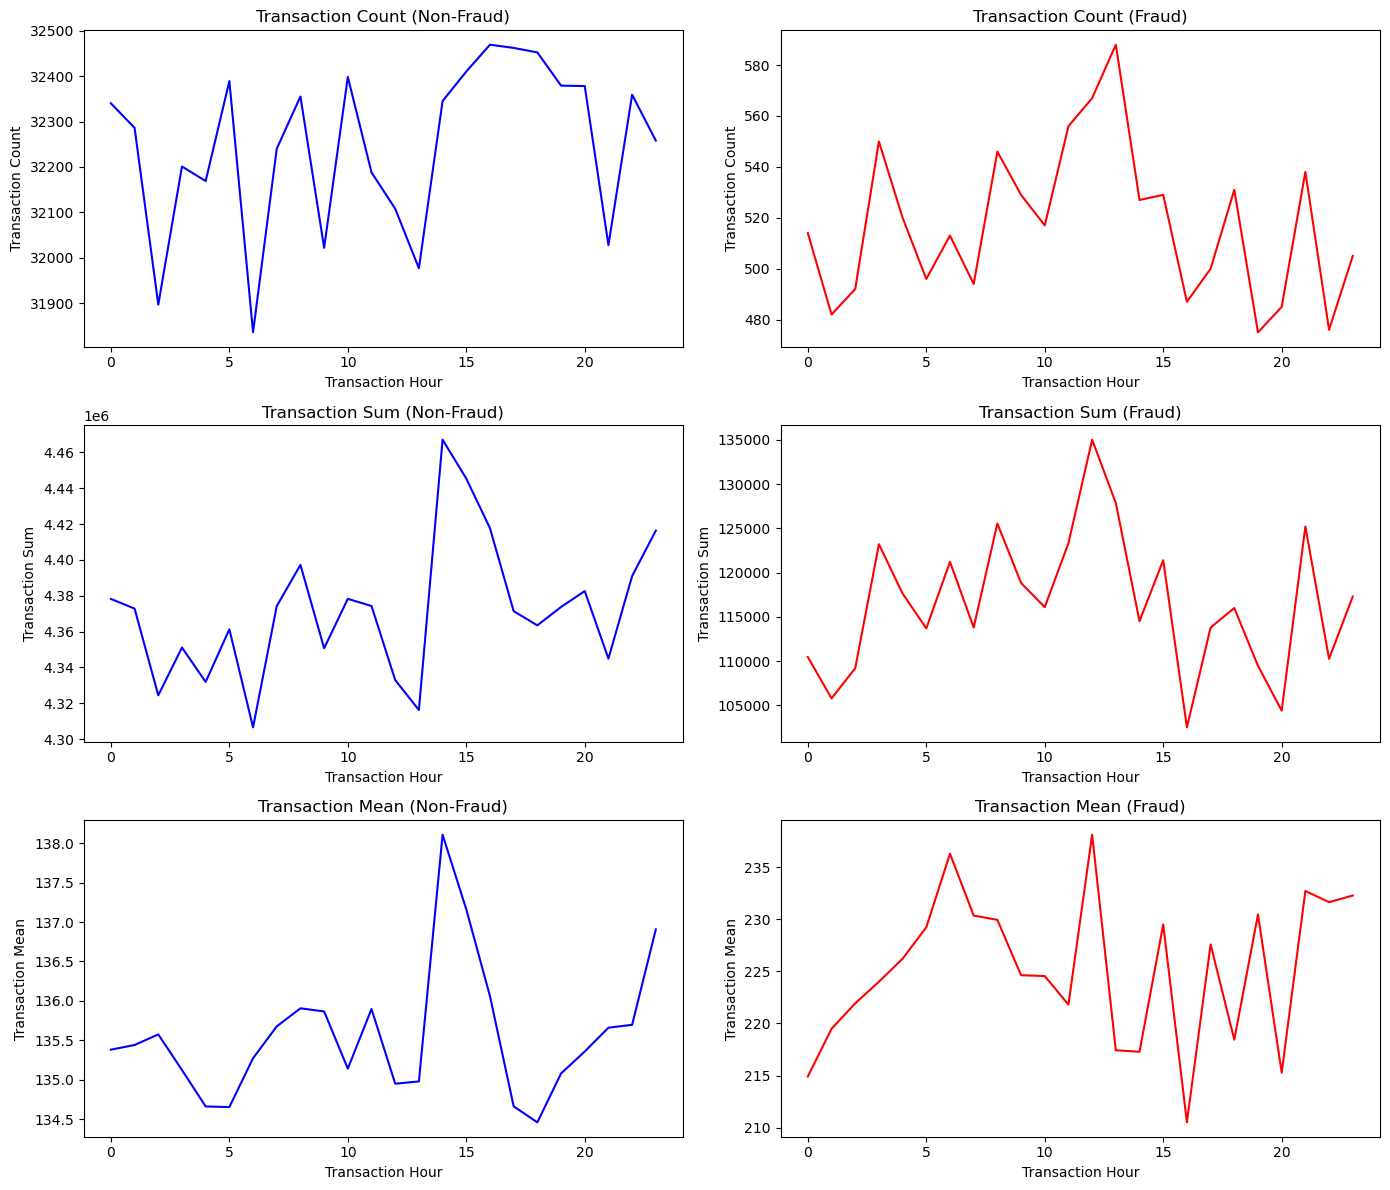

In [35]:
# transaction date time column
data['trans_month'] = (data['transactionDateTime'].dt.month).astype('int64') # extract month
data['trans_day'] = (data['transactionDateTime'].dt.day).astype('int64') # extract day
data['trans_hour'] = (data['transactionDateTime'].dt.hour).astype('int64') # extract hour
data['is_weekend'] = (data['transactionDateTime'].dt.dayofweek >= 5).astype('int64')  # 1 for Saturday and Sunday, 0 for weekdays


hour_trans = data.groupby(['trans_hour', 'isFraud'])['transactionAmount'].aggregate(['count', 'sum','mean']).reset_index()
hour_trans_df = pd.DataFrame(hour_trans, columns = ['trans_hour', 'isFraud','count',  'sum','mean'])

# Set up a 3x2 grid for subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
metrics = ['count', 'sum', 'mean']
titles = ['Transaction Count', 'Transaction Sum', 'Transaction Mean']

# Plot for non-fraudulent transactions
for i, metric in enumerate(metrics):
    sns.lineplot(ax=axes[i, 0], x='trans_hour', y=metric, data=hour_trans_df.loc[hour_trans_df.isFraud == 0], color='blue')
    axes[i, 0].set_title(f"{titles[i]} (Non-Fraud)")
    axes[i, 0].set_xlabel("Transaction Hour")
    axes[i, 0].set_ylabel(titles[i])

# Plot for fraudulent transactions
for i, metric in enumerate(metrics):
    sns.lineplot(ax=axes[i, 1], x='trans_hour', y=metric, data=hour_trans_df.loc[hour_trans_df.isFraud == 1], color='red')
    axes[i, 1].set_title(f"{titles[i]} (Fraud)")
    axes[i, 1].set_xlabel("Transaction Hour")
    axes[i, 1].set_ylabel(titles[i])

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

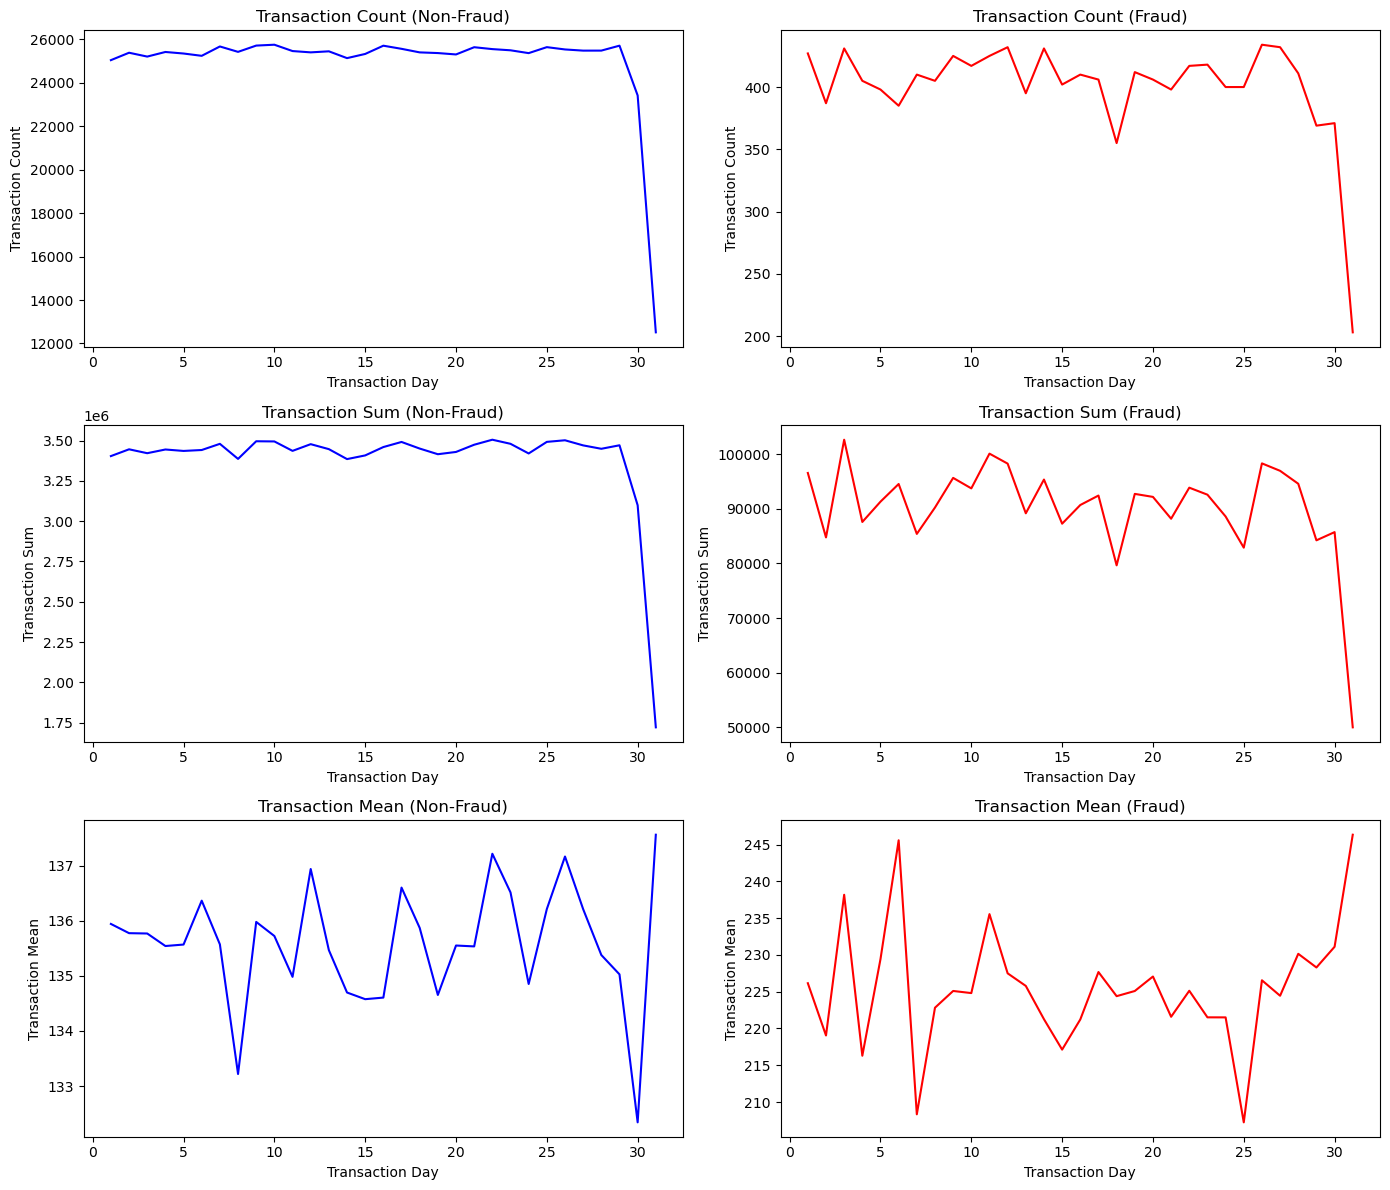

In [36]:
trans_day = data.groupby(['trans_day', 'isFraud'])['transactionAmount'].aggregate(['count', 'sum','mean']).reset_index()
trans_day_df = pd.DataFrame(trans_day, columns = ['trans_day', 'isFraud','count',  'sum','mean'])

# Set up a 3x2 grid for subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
metrics = ['count', 'sum', 'mean']
titles = ['Transaction Count', 'Transaction Sum', 'Transaction Mean']

# Plot for non-fraudulent transactions
for i, metric in enumerate(metrics):
    sns.lineplot(ax=axes[i, 0], x='trans_day', y=metric, data=trans_day_df.loc[trans_day_df.isFraud == 0], color='blue')
    axes[i, 0].set_title(f"{titles[i]} (Non-Fraud)")
    axes[i, 0].set_xlabel("Transaction Day")
    axes[i, 0].set_ylabel(titles[i])

# Plot for fraudulent transactions
for i, metric in enumerate(metrics):
    sns.lineplot(ax=axes[i, 1], x='trans_day', y=metric, data=trans_day_df.loc[trans_day_df.isFraud == 1], color='red')
    axes[i, 1].set_title(f"{titles[i]} (Fraud)")
    axes[i, 1].set_xlabel("Transaction Day")
    axes[i, 1].set_ylabel(titles[i])

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

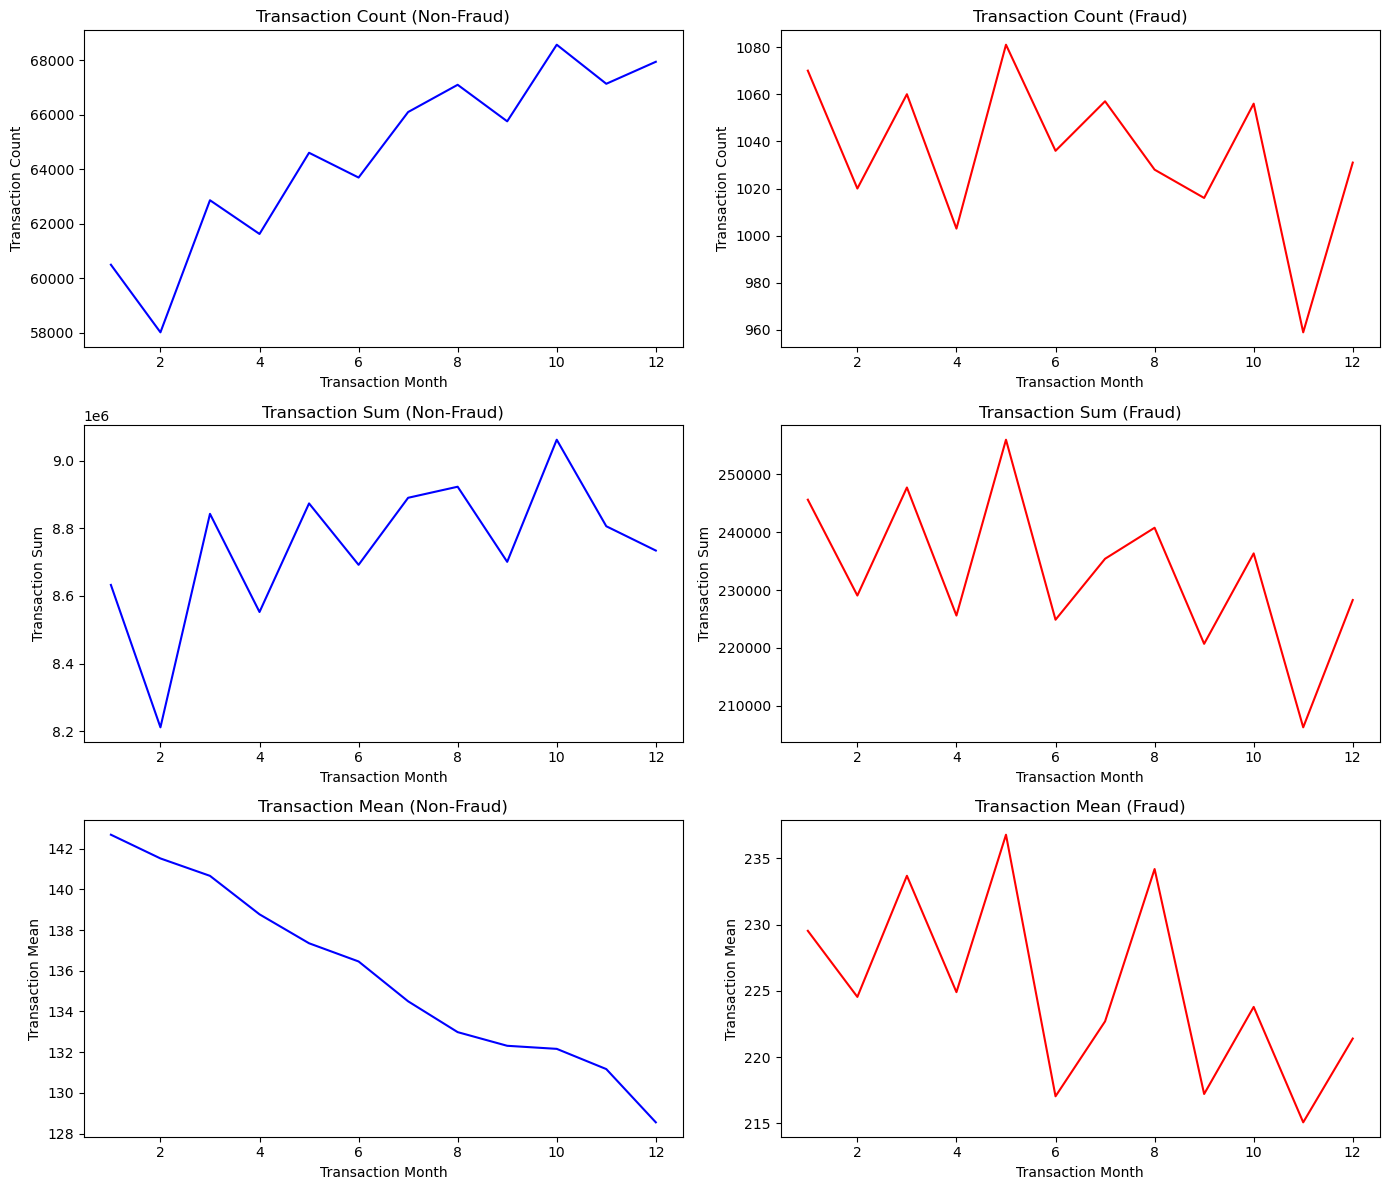

In [39]:
trans_month = data.groupby(['trans_month', 'isFraud'])['transactionAmount'].aggregate(['count', 'sum','mean']).reset_index()
trans_month_df = pd.DataFrame(trans_month, columns = ['trans_month', 'isFraud','count',  'sum','mean'])

# Set up a 3x2 grid for subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
metrics = ['count', 'sum', 'mean']
titles = ['Transaction Count', 'Transaction Sum', 'Transaction Mean']

# Plot for non-fraudulent transactions
for i, metric in enumerate(metrics):
    sns.lineplot(ax=axes[i, 0], x='trans_month', y=metric, data=trans_month_df.loc[trans_month_df.isFraud == 0], color='blue')
    axes[i, 0].set_title(f"{titles[i]} (Non-Fraud)")
    axes[i, 0].set_xlabel("Transaction Month")
    axes[i, 0].set_ylabel(titles[i])

# Plot for fraudulent transactions
for i, metric in enumerate(metrics):
    sns.lineplot(ax=axes[i, 1], x='trans_month', y=metric, data=trans_month_df.loc[trans_month_df.isFraud == 1], color='red')
    axes[i, 1].set_title(f"{titles[i]} (Fraud)")
    axes[i, 1].set_xlabel("Transaction Month")
    axes[i, 1].set_ylabel(titles[i])

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

In [41]:
pd.crosstab(data['is_weekend'], data['isFraud'])

isFraud          0     1
is_weekend              
0           553797  8970
1           220149  3447

In [44]:
# for each customer calculate the time difference between transactions
data = data.sort_values(by=['customerId', 'transactionDateTime'])
data['time_diff_transaction'] = data.groupby('customerId')['transactionDateTime'].diff().dt.total_seconds() / 60
data['time_diff_transaction'] = data['time_diff_transaction'].fillna(0)

# create time differece between trancaction time and account open date
data['diff_trans_openAc'] = (data['transactionDateTime'] - data['accountOpenDate']).dt.days

# create time differece between trancaction time and currentExpDate
data['diff_trans_Exp'] = (data['currentExpDate'] - data['transactionDateTime']).dt.days

# create time differece between trancaction time and dateOfLastAddressChange
data['diff_trans_addres'] = (data['transactionDateTime'] - data['dateOfLastAddressChange']).dt.days

In [46]:
data = data.sort_index()

In [48]:
data.columns

Index(['customerId', 'creditLimit', 'availableMoney', 'transactionDateTime',
       'transactionAmount', 'merchantName', 'acqCountry',
       'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardLast4Digits', 'transactionType',
       'currentBalance', 'cardPresent', 'expirationDateKeyInMatch', 'isFraud',
       'cvvMatch', 'trans_month', 'trans_day', 'trans_hour', 'is_weekend',
       'time_diff_transaction', 'diff_trans_openAc', 'diff_trans_Exp',
       'diff_trans_addres'],
      dtype='object')

In [51]:
data.drop(columns = ['transactionDateTime', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange'], 
          axis = 1, inplace = True)

### Categorical Columns

In [54]:
categorical_col = data.select_dtypes(['object']).columns
categorical_col

Index(['customerId', 'merchantName', 'acqCountry', 'merchantCountryCode',
       'posEntryMode', 'posConditionCode', 'merchantCategoryCode',
       'cardLast4Digits', 'transactionType'],
      dtype='object')

In [55]:
data[categorical_col].nunique()

customerId              5000
merchantName             174
acqCountry                 5
merchantCountryCode        5
posEntryMode               6
posConditionCode           4
merchantCategoryCode      13
cardLast4Digits         5246
transactionType            4
dtype: int64

In [57]:
col_cat =data[['acqCountry', 'posEntryMode', 'posConditionCode', 
               'cardLast4Digits', 'transactionType','transactionAmount','isFraud']]
data_col = col_cat.pivot_table( index = ['acqCountry', 'transactionType'],
                    columns = 'isFraud',
                    values = 'transactionAmount',
                    aggfunc = {'transactionAmount' : ['sum']},
                   fill_value = 0)
data_col['%amount_fraud'] = data_col['sum'][1]/data_col['sum'][0]
data_col.sort_values(by = '%amount_fraud', ascending = False)

sum             %amount_fraud
isFraud                                     0           1              
acqCountry transactionType                                             
CAN        Other                 6.866700e+02      152.41      0.221955
Other      REVERSAL              1.537575e+04     1966.72      0.127911
CAN        REVERSAL              7.982210e+03      610.69      0.076506
Other      PURCHASE              5.753465e+05    36753.53      0.063881
CAN        PURCHASE              3.119019e+05    12805.01      0.041055
US         Other                 1.019107e+05     4014.01      0.039388
MEX        PURCHASE              4.049510e+05    13344.96      0.032955
PR         PURCHASE              1.951575e+05     6418.95      0.032891
US         REVERSAL              2.703860e+06    74234.39      0.027455
           PURCHASE              1.005874e+08  2646205.22      0.026308
MEX        Other                 1.203400e+03        0.00      0.000000
           REVERSAL              1.203020e+04        0.00      0.000000
Other      Other                 4.728500e+02        0.00      0.000000
PR         Other                 1.971000e+01        0.00      0.000000
           REVERSAL              5.732870e+03        0.00      0.000000
CAN        ADDRESS_VERIFICATION  0.000000e+00        0.00           NaN
MEX        ADDRESS_VERIFICATION  0.000000e+00        0.00           NaN
Other      ADDRESS_VERIFICATION  0.000000e+00        0.00           NaN
PR         ADDRESS_VERIFICATION  0.000000e+00        0.00           NaN
US         ADDRESS_VERIFICATION  0.000000e+00        0.00           NaN

In [59]:
data_tranType = pd.crosstab(data['transactionType'], data['isFraud'])
data_tranType['rate'] = data_tranType[1]/data_tranType[0]
data_tranType

isFraud                    0      1      rate
transactionType                              
ADDRESS_VERIFICATION   20053    116  0.005785
Other                    684     14  0.020468
PURCHASE              733243  11950  0.016297
REVERSAL               19966    337  0.016879

In [60]:
data.nunique()

customerId                    5000
creditLimit                     10
availableMoney              521916
transactionAmount            66038
merchantName                   174
acqCountry                       5
merchantCountryCode              5
posEntryMode                     6
posConditionCode                 4
merchantCategoryCode            13
cardLast4Digits               5246
transactionType                  4
currentBalance              487318
cardPresent                      2
expirationDateKeyInMatch         2
isFraud                          2
cvvMatch                         2
trans_month                     12
trans_day                       31
trans_hour                      24
is_weekend                       2
time_diff_transaction       288057
diff_trans_openAc             5102
diff_trans_Exp                5356
diff_trans_addres             4810
dtype: int64

In [61]:
cus_id = data.pivot_table(
    index='customerId', 
    columns='isFraud', 
    values='transactionAmount', 
    aggfunc={'transactionAmount': ['count', 'sum']}, 
    fill_value=0
)
cus_count_More50 = cus_id[cus_id['count'][1] > 50].index
data['customerId'] = data['customerId'].apply(lambda x: x if x in cus_count_More50 else 'Other')
data['customerId'].value_counts()

customerId
Other        653290
380680241     32850
882815134     13189
570884863     10867
246251253     10172
369308035      7229
724518977      6283
419709514      5930
832842201      5850
208319653      5235
410523603      4825
269616174      3643
132629755      3456
700725639      3313
937269523      2804
307632490      2637
782081187      2435
654507597      2319
793511392      1857
794398270      1810
472288969      1790
247130864      1301
137196389       918
955678177       607
833207095       565
148207119       489
374358603       487
838703913       212
Name: count, dtype: int64

In [63]:
card_digit = data.pivot_table(
    index='cardLast4Digits', 
    columns='isFraud', 
    values='transactionAmount', 
    aggfunc={'transactionAmount': ['count', 'sum']}, 
    fill_value=0
)
card_digit_More50 = card_digit[card_digit['count'][1] > 50].index
data['cardLast4Digits'] = data['cardLast4Digits'].apply(lambda x: x if x in card_digit_More50 else 'Other')
data['cardLast4Digits'].value_counts()

cardLast4Digits
Other    669716
593       32946
2194      10867
6002      10172
8502       6553
2178       5930
0000       5492
7629       5235
2701       4826
6674       3635
9311       3632
8208       3456
9522       3313
6698       2804
4127       2319
3559       1885
3078       1804
3391       1599
7654       1318
2376       1301
7256       1174
8971        923
1991        910
3791        900
1142        867
1490        645
6855        565
924         544
6449        489
5375        278
3351        265
Name: count, dtype: int64

### Numerical Columns

In [66]:
numerical_feat = data.select_dtypes(['int64', 'float']).columns
len(numerical_feat)

16

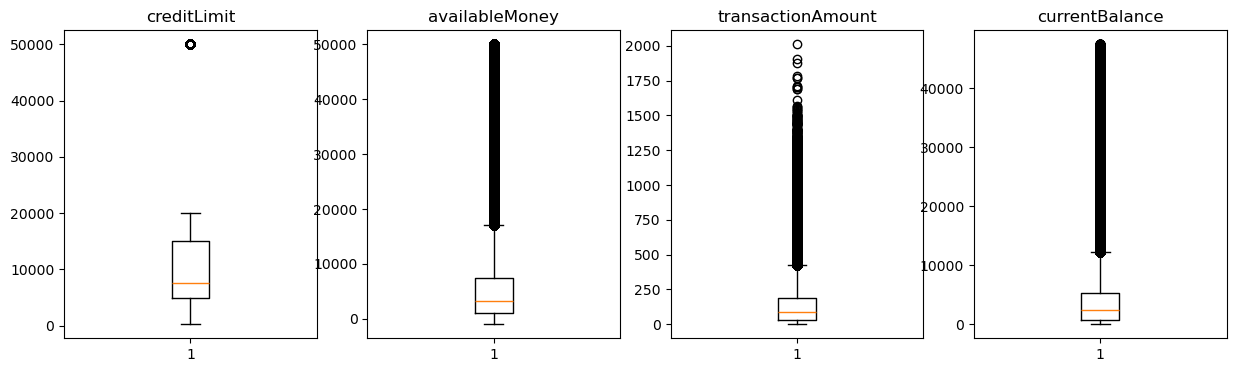

In [68]:
col_box = ['creditLimit', 'availableMoney', 'transactionAmount' , 'currentBalance']
figure, axis = plt.subplots(1, 4, figsize = (15,4))
for i in range(4):
    axis[i].boxplot(data[col_box[i]])
    axis[i].set_title(col_box[i])
    

In [69]:
print(f'number of outliers in creditLimit columns is {data[data['creditLimit'] > 40000].shape[0]}')
print(f'number of outliers in availableMoney columns is {data[data['availableMoney'] > 20000].shape[0]}')
print(f'number of outliers in transactionAmount columns is {data[data['transactionAmount'] > 1500].shape[0]}')
print(f'number of outliers in currentBalance columns is {data[data['currentBalance'] > 40000].shape[0]}')

number of outliers in creditLimit columns is 48781
number of outliers in availableMoney columns is 35051
number of outliers in transactionAmount columns is 25
number of outliers in currentBalance columns is 6127


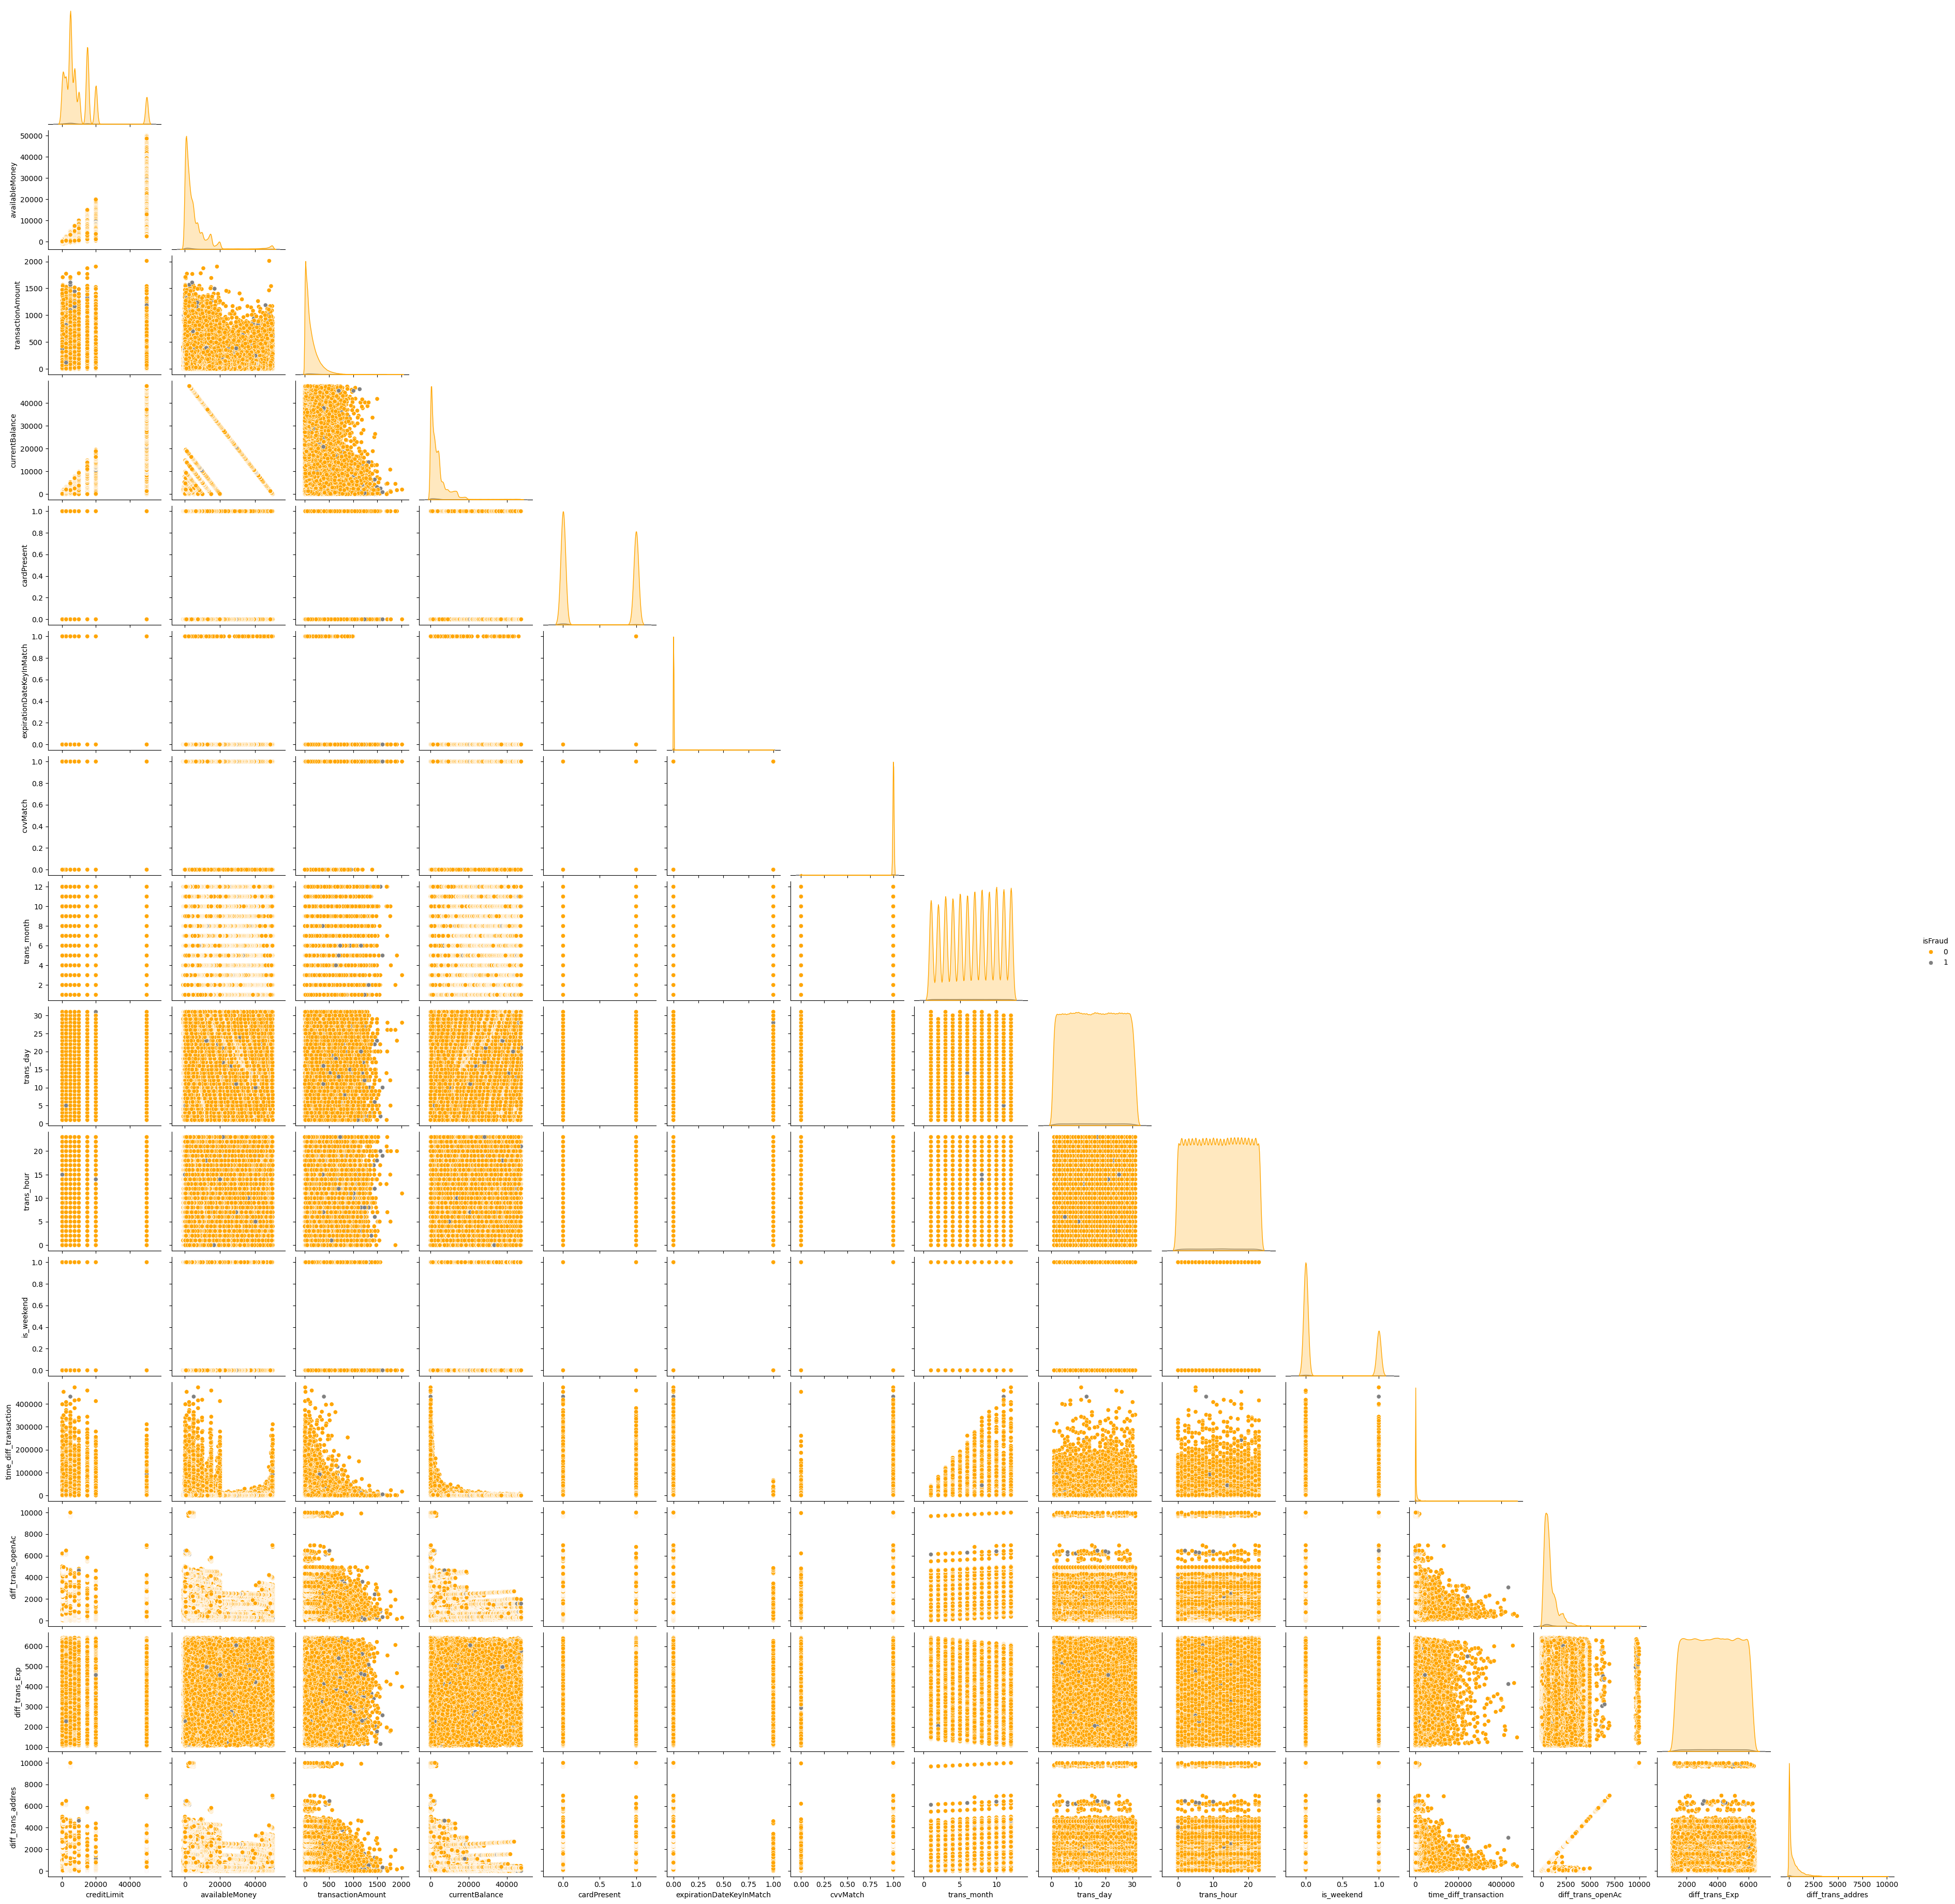

In [72]:
sns.pairplot(data[numerical_feat], hue="isFraud" , palette={1: "grey",0: "orange"},
                              diag_kind='auto', corner=True)

In [74]:
data.to_csv('data.csv', index=False)

### Data Split & Transformation

In [ ]:
X = data.drop(columns=['isFraud'], axis=1)
y = data['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Select numerical and categorical columns
numerical_col = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_col = X_train.select_dtypes(include=['object']).columns

# Define ColumnTransformer
ct = ColumnTransformer([
    ('scaler', StandardScaler(), numerical_col),  
    ('onehot', OneHotEncoder(drop="first", dtype=int, sparse_output=False), categorical_col)  
])

# First, fit the ColumnTransformer
ct.fit(X_train)  # Required before accessing `get_feature_names_out`

# Extract feature names
categorical_feature_names = ct.named_transformers_["onehot"].get_feature_names_out(categorical_col).tolist()
feature_names = list(numerical_col) + categorical_feature_names

# Transform and create DataFrame
X_transformed = pd.DataFrame(ct.transform(X_train), columns=feature_names)

X_transformed

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)  # Set the number of components you want to keep (e.g., 2)
pca_result = pca.fit_transform(X_transformed)

# Step 3: Create a DataFrame with the principal components
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
pca_df

In [ ]:
pca_df['target'] = y_train

# Step 4: Plot the PCA result using Seaborn with 'hue' based on the target variable
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='target', palette='viridis',  s=100)
plt.title('PCA of Data with Hue = y_train')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Target Variable', loc='best')
plt.show()